In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

import gensim
from gensim.models import Word2Vec

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout

In [2]:
# Importing dataset

df = pd.read_csv("training_set.csv")
df.head()

,label,cleaned_article,num_punctuations,no_of_stopwords,no_of_quesMarks,no_of_exclamation,no_of_sentence,sentiment,cc_cd,determiner,...,noun,adverb,verb,article_len,negations,polarity,word_count,avg_word_len,num_unique_words,num_chars
0,1,seeking best woman final return fridaysunday y...,139,634,5,0,41,Positive,37,98,...,236,27,150,4563,6,0.049887,357,6.392157,234,2638
1,0,harsh reality come taking responsibility life ...,112,702,2,3,37,Positive,53,79,...,196,85,230,5470,15,0.029320,347,6.573487,263,2627
2,0,finally obama speaks american need reconcile t...,65,415,1,0,21,Positive,17,67,...,145,28,116,3324,2,0.222891,244,6.950820,172,1939
3,1,house plan increase trump disaster request was...,46,221,0,0,9,Negative,19,19,...,87,5,33,1514,0,-0.062500,127,7.385827,97,1064
4,1,leftist cusp power weary icelander poll reykja...,89,523,0,0,26,Positive,35,67,...,193,16,120,3851,0,0.134749,313,6.872204,230,2463


In [3]:
df.isna().sum()
df.fillna("", inplace = True)

df = df.sample(frac = 1)
df.reset_index(inplace = True)

In [4]:
# Function to predict on test dataset and classify as real or fake

def prediction_result(model, test_df):
    y_pred = model.predict(test_df)   # Prediction on 1st test dataset
    prediction = []

# If predicted value is greater than 0.5 then mark it as real (label 1) else fake (label 0)
    for i in range(len(test_df)):
        if y_pred[i].item() > 0.5:
            prediction.append(1)
        else:
            prediction.append(0)  
    
    return prediction


In [5]:
def confusion_mat(actual, predicted):
    
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(actual, predicted)

    ax = sn.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Fake','Real'])
    ax.yaxis.set_ticklabels(['Fake','Real'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [6]:
def plot_loss_n_accuracy(history):
    print(history.history.keys())

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [7]:
X = [sent.split() for sent in df.cleaned_article.tolist()]
len(X[0])

13

In [8]:
# Training word2vec

DIM = 500

w2v_model = Word2Vec(
    sentences=X,
    vector_size  = DIM,
    window = 5,
    min_count = 1,
    workers = 4
)

In [9]:
print("Length of word2vec vectors: ",len(w2v_model.wv.key_to_index))
#w2v_model.wv.key_to_index

Length of word2vec vectors:  292578


In [10]:
w2v_model.wv.most_similar('mumbai')

[('delhi', 0.6821897625923157),
 ('chennai', 0.6439680457115173),
 ('karachi', 0.641853392124176),
 ('hyderabad', 0.6038353443145752),
 ('srinagar', 0.5978263020515442),
 ('dhaka', 0.5919310450553894),
 ('bombay', 0.585334062576294),
 ('gurgaon', 0.5820416808128357),
 ('quetta', 0.578901469707489),
 ('kuala', 0.5767115354537964)]

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 250000
tokenizer = Tokenizer(num_words = MAX_NB_WORDS) # num_words = MAX_NB_WORDS, lower = True
tokenizer.fit_on_texts(X)

sequence = tokenizer.texts_to_sequences(X) # Creating sequence of tokens
print(sequence[0])

word_index = tokenizer.word_index
word_index

[209, 420, 28569, 951, 1103, 321, 372, 2556, 772, 2126, 108, 337, 18]


{'trump': 1,
 'state': 2,
 'people': 3,
 'president': 4,
 'time': 5,
 'year': 6,
 'clinton': 7,
 'like': 8,
 'american': 9,
 'republican': 10,
 'government': 11,
 'country': 12,
 'house': 13,
 'election': 14,
 'obama': 15,
 'united': 16,
 'news': 17,
 'campaign': 18,
 'hillary': 19,
 'right': 20,
 'donald': 21,
 'white': 22,
 'official': 23,
 'party': 24,
 'world': 25,
 'told': 26,
 'group': 27,
 'know': 28,
 'want': 29,
 'woman': 30,
 'medium': 31,
 'going': 32,
 'think': 33,
 'york': 34,
 'week': 35,
 'million': 36,
 'political': 37,
 'national': 38,
 'russia': 39,
 'police': 40,
 'vote': 41,
 'work': 42,
 'percent': 43,
 'city': 44,
 'washington': 45,
 'thing': 46,
 'america': 47,
 'come': 48,
 'security': 49,
 'need': 50,
 'public': 51,
 'report': 52,
 'policy': 53,
 'according': 54,
 'company': 55,
 'court': 56,
 'life': 57,
 'month': 58,
 'case': 59,
 'support': 60,
 'video': 61,
 'including': 62,
 'email': 63,
 'member': 64,
 'democrat': 65,
 'administration': 66,
 'leader': 67,

In [12]:
# Padding vectors to length of 500 values.
# padding is set to POST which mean zero will be added to the end of vector if length of article is less than 500

from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 500
train_data = pad_sequences(sequence, maxlen=maxlen, padding = 'post')

In [13]:
train_data[0]

array([  209,   420, 28569,   951,  1103,   321,   372,  2556,   772,
        2126,   108,   337,    18,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [14]:
# Creating weight matrix and setting all values to zero

vocab_size = len(tokenizer.word_index) + 1
weight_matrix = np.zeros((vocab_size, DIM)) 

In [15]:
# Function to create weight matrix. Weight matrix will store word2vec value of each word

def get_weight_matrix(model, vocab):
    i = 0
    for word,i in vocab.items():
        try:
            if i > MAX_NB_WORDS:
                continue
                
            weight_matrix[i] = model.wv[word]
        except:
            continue
        #print(i)
    return weight_matrix

In [16]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)
embedding_vectors[50]

array([-1.02856743, -0.7701062 ,  1.06789601,  0.05454836,  0.49369013,
        0.0637641 , -0.32688281, -3.51220155,  0.22182795, -0.55728203,
       -1.20968628,  0.30757153, -0.40203279, -0.16307792, -0.89651269,
       -1.0898515 ,  0.22763649, -1.20242906, -0.09721372,  0.65465254,
        0.86517459,  0.23676537, -0.10646517,  0.34744468, -1.33788145,
       -0.62681586,  1.01539278,  0.80578983,  2.32612562,  0.43858686,
       -0.49095932, -0.06830016,  1.87655723, -0.46831548, -1.42951524,
       -0.58576596,  0.52812129, -1.22973883, -1.09981704,  0.27260438,
       -0.16075566, -0.5101105 ,  0.25512236, -0.29950222, -0.30190361,
        1.78923702,  1.63687503, -0.41692308, -0.93081349, -0.96817541,
        0.93400651,  0.94549513, -1.38152313,  0.22214928, -0.16885929,
       -0.52883792, -0.15784633,  1.00343227, -0.45702147,  0.67855704,
       -0.83500832,  0.45088825, -0.4398984 ,  1.00612748,  1.35424709,
        0.68986702,  0.13614309, -0.39383119,  0.44508636, -1.46

In [17]:
w2v_model.wv['india']

array([-9.94348526e-02,  1.19836593e+00, -4.45718616e-01, -4.84085590e-01,
        6.71274066e-01,  7.93033615e-02, -5.73829055e-01, -9.79483485e-01,
       -2.63276666e-01, -7.45616794e-01,  3.75732422e-01,  1.59427965e+00,
       -2.74350196e-01,  1.85479760e+00, -1.05182743e+00, -9.65467572e-01,
        7.79573917e-01,  8.10985863e-01,  1.21903539e+00, -1.31349361e+00,
        2.44580925e-01, -3.04538429e-01,  6.76723778e-01, -1.36580825e+00,
       -1.00815967e-01,  1.61969066e-02, -1.28825986e+00, -8.36380184e-01,
       -1.42952546e-01, -7.85467625e-01, -4.46215302e-01, -2.41695821e-01,
       -1.57294822e+00, -6.43353224e-01, -2.24198833e-01, -8.49344552e-01,
        5.88027537e-01, -8.65465850e-02,  6.33952439e-01,  1.59764600e+00,
        1.70498252e-01, -3.86501491e-01, -1.15316784e+00, -1.74475980e+00,
       -1.78100562e+00, -2.04211164e+00,  9.35721278e-01, -5.97505987e-01,
       -9.70586836e-01, -1.48067296e-01, -4.55639452e-01,  3.17574084e-01,
       -5.58579415e-02, -

In [18]:
print("Shape of Embedding Vectors is :",embedding_vectors.shape)

Shape of Embedding Vectors is : (292579, 500)


In [19]:
# Spliting the data in training and test set

from sklearn.model_selection import train_test_split
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(train_data,y, test_size = 0.2)

## Uni-LSTM

In [20]:
model1 = Sequential()
model1.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vectors], input_length = maxlen, trainable = False))
model1.add(Dropout(0.5))

model1.add(LSTM(units = 512))
model1.add(Dropout(0.5))

model1.add(Dense(128, activation = 'relu'))
model1.add(Dropout(0.5))

model1.add(Dense(1, activation = 'sigmoid'))
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [21]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 500)          146289500 
                                                                 
 dropout (Dropout)           (None, 500, 500)          0         
                                                                 
 lstm (LSTM)                 (None, 512)               2074624   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [22]:
history = model1.fit(X_train, y_train, batch_size = 128, validation_split = 0.2, epochs = 10)

2022-02-10 06:33:45.233654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-02-10 06:33:47.748814: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


483/483 [==============================] - 87s 173ms/step - loss: 0.6571 - acc: 0.5704 - val_loss: 0.6432 - val_acc: 0.5688
Epoch 2/10
483/483 [==============================] - 83s 171ms/step - loss: 0.5767 - acc: 0.6694 - val_loss: 0.7249 - val_acc: 0.4879
Epoch 3/10
483/483 [==============================] - 84s 174ms/step - loss: 0.4338 - acc: 0.7911 - val_loss: 0.2509 - val_acc: 0.8840
Epoch 4/10
483/483 [==============================] - 84s 173ms/step - loss: 0.2288 - acc: 0.8993 - val_loss: 0.1771 - val_acc: 0.9146
Epoch 5/10
483/483 [==============================] - 83s 173ms/step - loss: 0.1925 - acc: 0.9091 - val_loss: 0.1585 - val_acc: 0.9234
Epoch 6/10
483/483 [==============================] - 84s 174ms/step - loss: 0.1615 - acc: 0.9217 - val_loss: 0.1473 - val_acc: 0.9252
Epoch 7/10
483/483 [==============================] - 84s 173ms/step - loss: 0.1450 - acc: 0.9283 - val_loss: 0.1372 - val_acc: 0.9292
Epoch 8/10
483/483 [==============================] - 84s 173ms/st

Plotting Accuracy and loss on validation data
dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


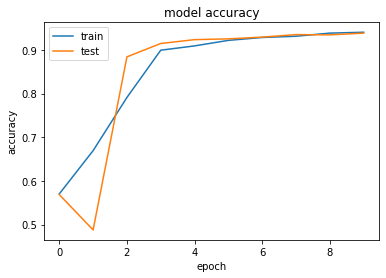

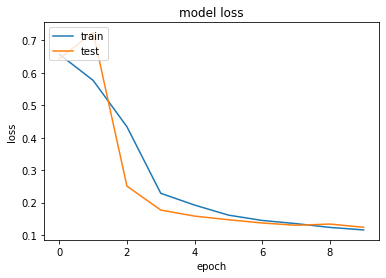

In [23]:
print("Plotting Accuracy and loss on validation data")
plot_loss_n_accuracy(history)

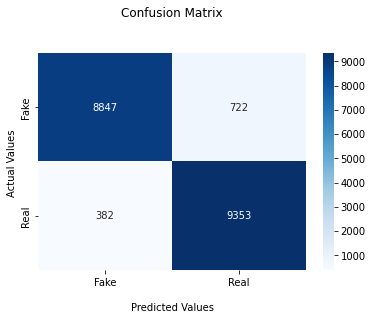

In [24]:
# Prediction on test set and plotting confusion matrix

prediction_lstm = prediction_result(model1, X_test)
confusion_mat(y_test, prediction_lstm)

In [25]:
print("Classification report of Test set: \n\n",classification_report(y_test, prediction_lstm, digits = 4))

Classification report of Test set: 

               precision    recall  f1-score   support

           0     0.9586    0.9245    0.9413      9569
           1     0.9283    0.9608    0.9443      9735

    accuracy                         0.9428     19304
   macro avg     0.9435    0.9427    0.9428     19304
weighted avg     0.9433    0.9428    0.9428     19304



## Bi-directional LSTM

In [156]:
model2 = Sequential()
#Non-trainable embeddidng layer
model2.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model2.add(Dropout(0.5))

model2.add(Bidirectional(LSTM(units=100)))
model2.add(Dropout(0.5))

model2.add(Dense(32, activation = 'relu'))
model2.add(Dropout(0.5))

model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [157]:
model2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 500, 500)          146289500 
_________________________________________________________________
dropout_54 (Dropout)         (None, 500, 500)          0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 200)               480800    
_________________________________________________________________
dropout_55 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_56 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)               

In [158]:
history1 = model2.fit(X_train, y_train, batch_size = 128, validation_split = 0.2, epochs = 6)

Epoch 1/6
483/483 [==============================] - 50s 98ms/step - loss: 0.3370 - acc: 0.8491 - val_loss: 0.2415 - val_acc: 0.9012
Epoch 2/6
483/483 [==============================] - 47s 97ms/step - loss: 0.2268 - acc: 0.9011 - val_loss: 0.1973 - val_acc: 0.9163
Epoch 3/6
483/483 [==============================] - 47s 97ms/step - loss: 0.1948 - acc: 0.9134 - val_loss: 0.1648 - val_acc: 0.9249
Epoch 4/6
483/483 [==============================] - 46s 96ms/step - loss: 0.1756 - acc: 0.9212 - val_loss: 0.1838 - val_acc: 0.9171
Epoch 5/6
483/483 [==============================] - 47s 97ms/step - loss: 0.1624 - acc: 0.9264 - val_loss: 0.1539 - val_acc: 0.9270
Epoch 6/6
483/483 [==============================] - 46s 96ms/step - loss: 0.1453 - acc: 0.9320 - val_loss: 0.1556 - val_acc: 0.9304


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


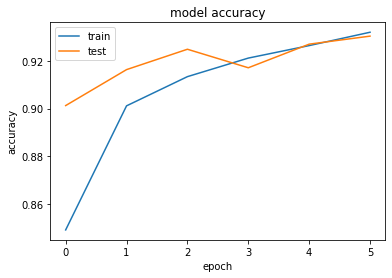

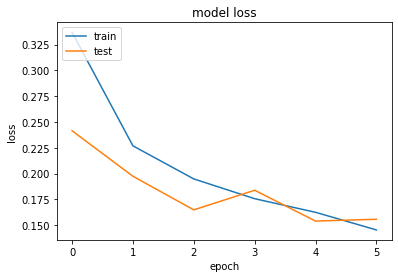

In [159]:
plot_loss_n_accuracy(history1)

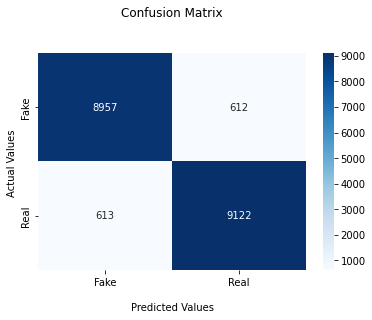

In [160]:
# Prediction on test set using bi-directional lstm

prediction_bilstm = prediction_result(model2, X_test)
confusion_mat(y_test, prediction_bilstm)

In [161]:
print(classification_report(y_test, prediction_bilstm, digits = 4))

              precision    recall  f1-score   support

           0     0.9359    0.9360    0.9360      9569
           1     0.9371    0.9370    0.9371      9735

    accuracy                         0.9365     19304
   macro avg     0.9365    0.9365    0.9365     19304
weighted avg     0.9365    0.9365    0.9365     19304



# Testing on test datasets

In [22]:
#Importing test datasets
test_df1 = pd.read_csv('Test/test1.csv')
test_df2 = pd.read_csv('Test/test2.csv')



In [34]:
# Droping if row does not contain any word.
# Resetting indexes
# for both test datasets

test_df1 = test_df1.drop(test_df1[test_df1['word_count']<=0].index)
test_df1.fillna("", inplace = True)
test_df1 = test_df1.sample(frac = 1)
test_df1.reset_index(inplace = True)


test_df2 = test_df2.drop(test_df2[test_df2['word_count']<=0].index)
test_df2.fillna("", inplace = True)
test_df2 = test_df2.sample(frac = 1)
test_df2.reset_index(inplace = True)

In [35]:
# Creating lists of words
X_df1 = [sent.split() for sent in test_df1.cleaned_article.tolist()]
X_df2 = [sent.split() for sent in test_df2.cleaned_article.tolist()]

# Storing actual labels
label_y1 = test_df1.label
label_y2 = test_df2.label

In [36]:
# Tokenizing word using Tokenizer created in training phase
sequence_df1 = tokenizer.texts_to_sequences(X_df1)
sequence_df2 = tokenizer.texts_to_sequences(X_df2)

In [37]:
# Padding sequence so all rows will be of same length
test_1 = pad_sequences(sequence_df1, maxlen=maxlen, padding = 'post')
test_2 = pad_sequences(sequence_df2, maxlen=maxlen, padding = 'post')

## LSTM prediction

### Test Dataset 1

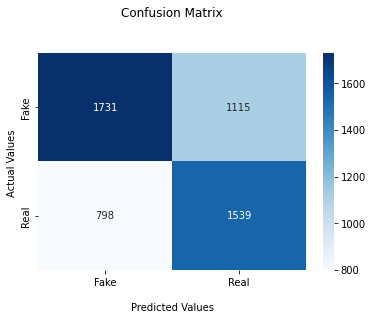

In [166]:
test1_pred_lstm = prediction_result(model1, test_1)
confusion_mat(label_y1, test1_pred_lstm)

In [167]:
print(classification_report(label_y1, test1_pred_lstm, digits = 4))

              precision    recall  f1-score   support

           0     0.6845    0.6082    0.6441      2846
           1     0.5799    0.6585    0.6167      2337

    accuracy                         0.6309      5183
   macro avg     0.6322    0.6334    0.6304      5183
weighted avg     0.6373    0.6309    0.6317      5183



### Test Dataset 2

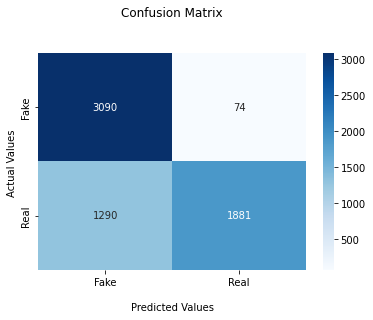

In [168]:
test2_pred_lstm = prediction_result(model1, test_2)
confusion_mat(label_y2, test2_pred_lstm)

In [169]:
print(classification_report(label_y2, test2_pred_lstm, digits = 4))

              precision    recall  f1-score   support

           0     0.7055    0.9766    0.8192      3164
           1     0.9621    0.5932    0.7339      3171

    accuracy                         0.7847      6335
   macro avg     0.8338    0.7849    0.7765      6335
weighted avg     0.8340    0.7847    0.7765      6335



## Bi-direction LSTM prediction

### Test Dataset 1

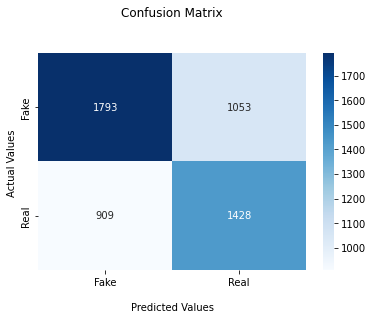

In [170]:
test1_pred_bilstm = prediction_result(model2, test_1)
confusion_mat(label_y1, test1_pred_bilstm)

In [171]:
print(classification_report(label_y1, test1_pred_bilstm, digits = 4))

              precision    recall  f1-score   support

           0     0.6636    0.6300    0.6464      2846
           1     0.5756    0.6110    0.5928      2337

    accuracy                         0.6215      5183
   macro avg     0.6196    0.6205    0.6196      5183
weighted avg     0.6239    0.6215    0.6222      5183



### Test Dataset 2

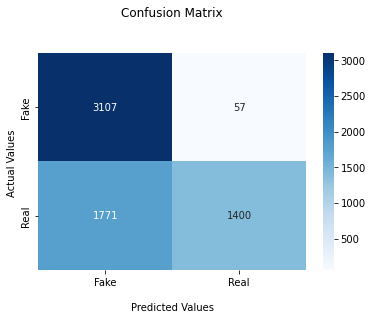

In [172]:
test2_pred_bilstm = prediction_result(model2, test_2)
confusion_mat(label_y2, test2_pred_bilstm)

In [173]:
print(classification_report(label_y2, test2_pred_bilstm, digits = 4))

              precision    recall  f1-score   support

           0     0.6369    0.9820    0.7727      3164
           1     0.9609    0.4415    0.6050      3171

    accuracy                         0.7114      6335
   macro avg     0.7989    0.7117    0.6889      6335
weighted avg     0.7991    0.7114    0.6888      6335



In [ ]:
model1.save_weights("model1.h5")
model2.save_weights("model2.h5")